# 데모

## 라이브러리 import 및 설정

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [28]:
from matplotlib import rcParams, pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
import re
from sklearn.metrics import accuracy_score, log_loss
from sklearn.model_selection import StratifiedKFold
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, GlobalMaxPooling1D, Conv1D, Dropout, Bidirectional
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.optimizers import Adam
import warnings 
warnings.filterwarnings(action='ignore')

In [4]:
rcParams['figure.figsize'] = (16, 8)
plt.style.use('fivethirtyeight')
pd.set_option('max_columns', 100)
pd.set_option("display.precision", 4)
warnings.simplefilter('ignore')

## 학습데이터 로드

In [5]:
main_path = Path('/content/drive/My Drive/Colab Notebooks/dacon_author')
feedMe_dir = main_path / 'feed_me' # 기본 feature들 있는 곳
medium_dir =  main_path / 'medium' # 중간 결과물 저장하는 곳
result_dir =  main_path / 'result' # 최종 결과물 저장하는 곳

trn_file = feedMe_dir / 'train.csv'
tst_file = feedMe_dir / 'test_x.csv'
sample_file = feedMe_dir / 'sample_submission.csv'

target_col = 'author'
n_fold = 5
n_class = 5
seed = 42

In [6]:
algo_name = 'lstm'
feature_name = 'emb'
model_name = f'{algo_name}_{feature_name}'

feature_file = medium_dir / 'feat' / f'{feature_name}.csv'
p_val_file = medium_dir / 'val' / f'{model_name}.val.csv'
p_tst_file = medium_dir / 'tst' / f'{model_name}.tst.csv'
sub_file = result_dir / f'{model_name}.csv'

In [7]:
train = pd.read_csv(trn_file, encoding = 'utf-8')
train.head()

,index,text,author
0,0,"He was almost choking. There was so much, so m...",3
1,1,"“Your sister asked for it, I suppose?”",2
2,2,"She was engaged one day as she walked, in per...",1
3,3,"The captain was in the porch, keeping himself ...",4
4,4,"“Have mercy, gentlemen!” odin flung up his han...",3


In [8]:
test = pd.read_csv(tst_file, encoding = 'utf-8')
test.head()

,index,text
0,0,“Not at all. I think she is one of the most ch...
1,1,"""No,"" replied he, with sudden consciousness, ""..."
2,2,As the lady had stated her intention of scream...
3,3,“And then suddenly in the silence I heard a so...
4,4,His conviction remained unchanged. So far as I...


## Preprocessing

In [9]:
def alpha_num(text):
    return re.sub(r'[^A-Za-z0-9 ]', '', text)


def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stopwords:
            final_text.append(i.strip())
    return " ".join(final_text)


stopwords = [ "a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", 
             "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", 
             "did", "do", "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", 
             "have", "having", "he", "he'd", "he'll", "he's", "her", "here", "here's", "hers", "herself", "him", "himself", 
             "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into", "is", "it", "it's", "its", "itself", 
             "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought", "our", "ours", 
             "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", "so", "some", "such", "than", "that", 
             "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's", "these", "they", "they'd", "they'll", 
             "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", "we", "we'd", "we'll", 
             "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's", "which", "while", "who", "who's", "whom", 
             "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves" ]

In [10]:
train['text'] = train['text'].str.lower()
test['text'] = test['text'].str.lower()
train['text'] = train['text'].apply(alpha_num).apply(remove_stopwords)
test['text'] = test['text'].apply(alpha_num).apply(remove_stopwords)

In [11]:
X_train = train['text'].values
X_test = test['text'].values
y = train['author'].values
print(X_train.shape, X_test.shape, y.shape)

(54879,) (19617,) (54879,)


In [12]:
X_train[:3]

array(['almost choking much much wanted say strange exclamations came lips pole gazed fixedly bundle notes hand looked odin evident perplexity',
       'sister asked suppose',
       'engaged one day walked perusing janes last letter dwelling passages proved jane not written spirits instead surprised mr odin saw looking odin meeting putting away letter immediately forcing smile said'],
      dtype=object)

## Training

In [13]:
vocab_size = 20000
embedding_dim = 64
max_length = 500
padding_type='post'

In [14]:
tokenizer = Tokenizer(num_words = vocab_size)
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index

In [15]:
train_sequences = tokenizer.texts_to_sequences(X_train)
test_sequences = tokenizer.texts_to_sequences(X_test)

In [16]:
trn = pad_sequences(train_sequences, padding=padding_type, maxlen=max_length)
tst = pad_sequences(test_sequences, padding=padding_type, maxlen=max_length)
print(trn.shape, tst.shape)

(54879, 500) (19617, 500)


In [17]:
cv = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=seed)

In [18]:
def get_model():
    model = Sequential([
        Embedding(vocab_size, embedding_dim, input_length=max_length),
        Bidirectional(LSTM(64, return_sequences=True)),
        Bidirectional(LSTM(64)),
        Dense(n_class, activation='softmax')
    ])
    
    model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=.01))
    return model

In [19]:
p_val = np.zeros((trn.shape[0], n_class))
p_tst = np.zeros((tst.shape[0], n_class))
for i, (i_trn, i_val) in enumerate(cv.split(trn, y), 1):
    print(f'training model for CV #{i}')
    clf = get_model()
    
    es = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=3,
                       verbose=1, mode='min', baseline=None, restore_best_weights=True)

    clf.fit(trn[i_trn], 
            to_categorical(y[i_trn]),
            validation_data=(trn[i_val], to_categorical(y[i_val])),
            epochs=10,
            callbacks=[es])
    p_val[i_val, :] = clf.predict(trn[i_val])
    p_tst += clf.predict(tst) / n_fold

training model for CV #1
Epoch 1/10
1372/1372 [==============================] - 1564s 1s/step - loss: 0.9942 - val_loss: 0.8058
Epoch 2/10
1372/1372 [==============================] - 1561s 1s/step - loss: 0.6183 - val_loss: 0.7817
Epoch 3/10
1372/1372 [==============================] - 1568s 1s/step - loss: 0.5020 - val_loss: 0.8029
Epoch 4/10
1372/1372 [==============================] - 1568s 1s/step - loss: 0.4515 - val_loss: 0.8466
Epoch 5/10
1372/1372 [==============================] - 1572s 1s/step - loss: 0.4256 - val_loss: 0.8872
Epoch 00005: early stopping
training model for CV #2
Epoch 1/10
1372/1372 [==============================] - 1574s 1s/step - loss: 0.9908 - val_loss: 0.7953
Epoch 2/10
1372/1372 [==============================] - 1569s 1s/step - loss: 0.6201 - val_loss: 0.8178
Epoch 3/10
1372/1372 [==============================] - 1566s 1s/step - loss: 0.5089 - val_loss: 0.8259
Epoch 4/10
1372/1372 [==============================] - 1572s 1s/step - loss: 0.4569 - val

In [20]:
print(f'Accuracy (CV): {accuracy_score(y, np.argmax(p_val, axis=1)) * 100:8.4f}%')
print(f'Log Loss (CV): {log_loss(pd.get_dummies(y), p_val):8.4f}')

Accuracy (CV):  71.4062%
Log Loss (CV):   0.7793


In [21]:
np.savetxt(p_val_file, p_val, fmt='%.6f', delimiter=',')
np.savetxt(p_tst_file, p_tst, fmt='%.6f', delimiter=',')

## 시각화

In [22]:
# model summary
print(clf.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 500, 64)           1280000   
_________________________________________________________________
bidirectional_8 (Bidirection (None, 500, 128)          66048     
_________________________________________________________________
bidirectional_9 (Bidirection (None, 128)               98816     
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 645       
Total params: 1,445,509
Trainable params: 1,445,509
Non-trainable params: 0
_________________________________________________________________
None


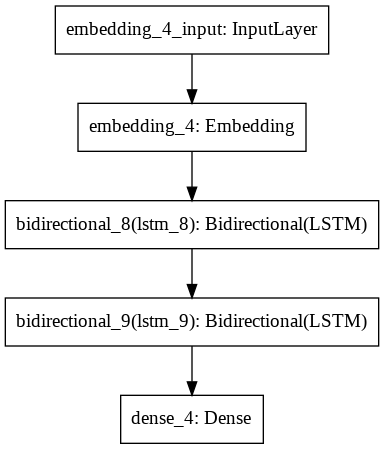

In [23]:
plot_model(clf)

## 제출 파일 생성

In [24]:
sub = pd.read_csv(sample_file, index_col=0)
print(sub.shape)
sub.head()

(19617, 5)


,0,1,2,3,4
index,,,,,
0,0,0,0,0,0
1,0,0,0,0,0
2,0,0,0,0,0
3,0,0,0,0,0
4,0,0,0,0,0


In [25]:
sub[sub.columns] = p_tst
sub.head()

,0,1,2,3,4
index,,,,,
0,0.0321,0.2912,0.3210,0.3359,0.0199
1,0.2652,0.3422,0.0207,0.0396,0.3324
2,0.7891,0.1906,0.0116,0.0030,0.0057
3,0.0184,0.0168,0.5038,0.0254,0.4356
4,0.2354,0.1565,0.0595,0.2936,0.2550


In [26]:
sub.to_csv(sub_file)